In [17]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU, Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

In [117]:
import yfinance as yf

ticker_symbol = 'MSFT'  

start_date = '2021-03-01'
end_date = '2024-03-31'

data = yf.download(ticker_symbol, start=start_date, end=end_date)

print(data.head())



[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-03-01  235.899994  237.470001  233.149994  236.940002  230.847702   
2021-03-02  237.009995  237.300003  233.449997  233.869995  227.856659   
2021-03-03  232.160004  233.580002  227.259995  227.559998  221.708893   
2021-03-04  226.740005  232.490005  224.259995  226.729996  220.900238   
2021-03-05  229.520004  233.270004  226.460007  231.600006  225.644989   

              Volume  
Date                  
2021-03-01  25324000  
2021-03-02  22812500  
2021-03-03  34029500  
2021-03-04  44727800  
2021-03-05  41872800  


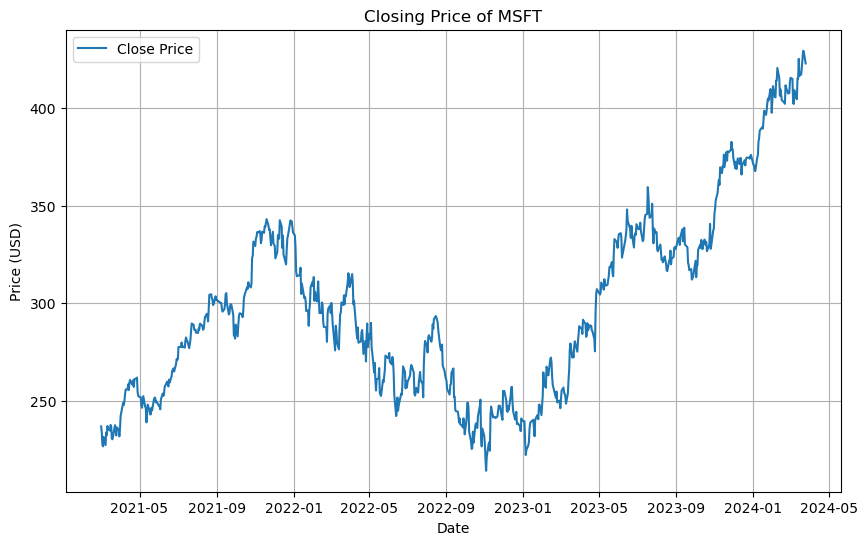

In [118]:

close_prices = data['Close']

plt.figure(figsize=(10, 6)) 
plt.plot(close_prices, label='Close Price') 
plt.title(f'Closing Price of {ticker_symbol}')  
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


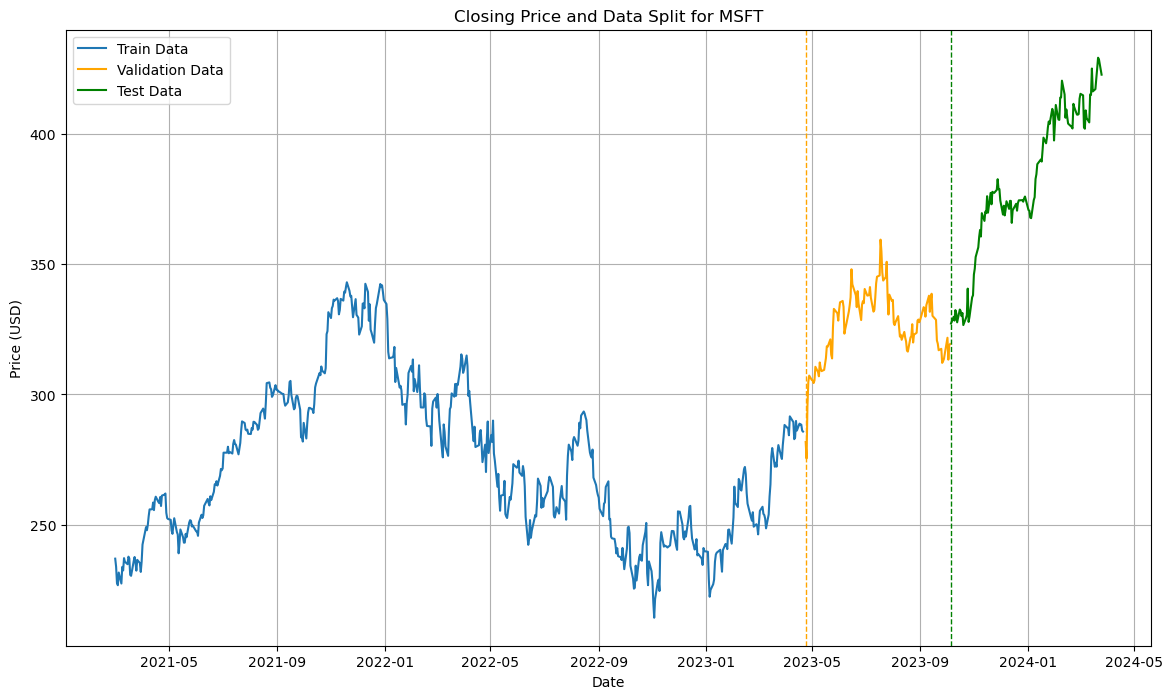

In [119]:
close_prices = data['Close']

train_size = int(len(close_prices) * 0.7)
validation_size = int(len(close_prices) * 0.15)
test_size = len(close_prices) - train_size - validation_size

train_data = close_prices[:train_size]
validation_data = close_prices[train_size:train_size + validation_size]
test_data = close_prices[train_size + validation_size:]

plt.figure(figsize=(14, 8))
plt.plot(train_data.index, train_data, label='Train Data')
plt.plot(validation_data.index, validation_data, label='Validation Data', color='orange')
plt.plot(test_data.index, test_data, label='Test Data', color='green')

plt.axvline(close_prices.index[train_size], color='orange', linestyle='--', linewidth=1)
plt.axvline(close_prices.index[train_size + validation_size], color='green', linestyle='--', linewidth=1)

plt.title(f'Closing Price and Data Split for {ticker_symbol}')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [120]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices.values.reshape(-1, 1))
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data)-sequence_length):
        x = data[i:(i+sequence_length)]
        y = data[i+sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 60 
X, y = create_sequences(scaled_data, sequence_length)

train_size = int(len(X) * 0.7)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [125]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(25),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [126]:
model.fit(X_train, y_train, batch_size=32, epochs=100)


Epoch 1/100
16/16 [==============================] - 14s 102ms/step - loss: 0.0320
Epoch 2/100
16/16 [==============================] - 1s 84ms/step - loss: 0.0066
Epoch 3/100
16/16 [==============================] - 1s 91ms/step - loss: 0.0036
Epoch 4/100
16/16 [==============================] - 1s 85ms/step - loss: 0.0028
Epoch 5/100
16/16 [==============================] - 2s 98ms/step - loss: 0.0025
Epoch 6/100
16/16 [==============================] - 2s 98ms/step - loss: 0.0023
Epoch 7/100
16/16 [==============================] - 2s 97ms/step - loss: 0.0022
Epoch 8/100
16/16 [==============================] - 2s 93ms/step - loss: 0.0022
Epoch 9/100
16/16 [==============================] - 1s 90ms/step - loss: 0.0021
Epoch 10/100
16/16 [==============================] - 2s 110ms/step - loss: 0.0019
Epoch 11/100
16/16 [==============================] - 1s 80ms/step - loss: 0.0019
Epoch 12/100
16/16 [==============================] - 1s 51ms/step - loss: 0.0018
Epoch 13/100
16/16 [==

16/16 [==============================] - 1s 64ms/step - loss: 6.0905e-04
Epoch 99/100
16/16 [==============================] - 1s 69ms/step - loss: 6.1345e-04
Epoch 100/100
16/16 [==============================] - 1s 56ms/step - loss: 6.0569e-04


In [127]:
train_predictions = model.predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions)  

actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))

train_rmse = np.sqrt(np.mean(np.square(actual_train - train_predictions)))
print(f"Training RMSE: {train_rmse}")


16/16 [==============================] - 3s 32ms/step
Training RMSE: 5.220814686969378


In [128]:
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)  

actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

test_rmse = np.sqrt(np.mean(np.square(actual_test - test_predictions)))
print(f"Test RMSE: {test_rmse}")


7/7 [==============================] - 0s 20ms/step
Test RMSE: 5.233822798103157


1/1 [==============================] - 0s 61ms/step


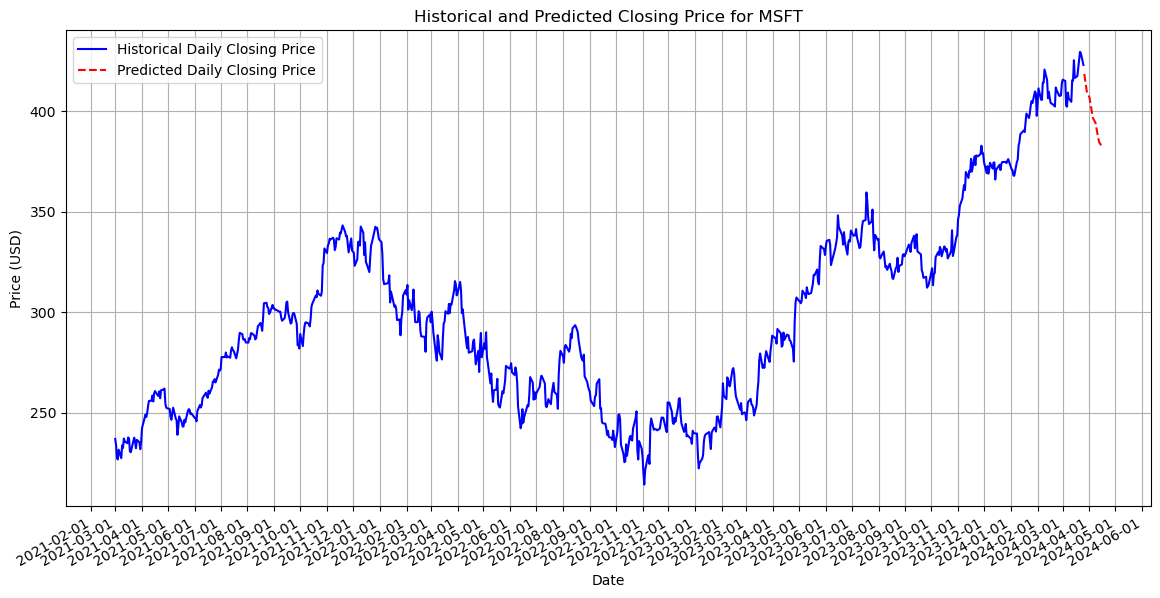

In [130]:

new_sequence = scaled_data[-sequence_length:]

new_sequence = new_sequence.reshape((1, sequence_length, 1))

predictions = []

num_days_to_predict = 15

for _ in range(num_days_to_predict):
    next_day_prediction = model.predict(new_sequence)
    
    predictions.append(next_day_prediction.flatten()[0])
    
    new_sequence = np.append(new_sequence[:,1:,:], [next_day_prediction], axis=1)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

historical_prices = scaler.inverse_transform(scaled_data).flatten()

last_historical_date = data.index[-1]
future_dates = pd.date_range(start=last_historical_date, periods=num_days_to_predict + 1, freq='B')[1:]

register_matplotlib_converters()

plt.figure(figsize=(14, 7))

plt.plot(data.index, historical_prices, label='Historical Daily Closing Price', color='blue')

plt.plot(future_dates, predictions, label='Predicted Daily Closing Price', color='red', linestyle='--')

plt.title(f'Historical and Predicted Closing Price for {ticker_symbol}')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  

plt.show()
